#### Importing Functions

In [1]:
from utils import *

#### Importing the libraries

In [2]:
import cv2
import os
import tifffile # for reading tiff files. There are other modules that can do this, but tifffile is most stable on Windows
import numpy as np # for array handling
import matplotlib.pyplot as plt # for QC
import glob # to gather up image filepath lists
import rasterio
from rasterio.plot import show
from skimage import io
import scipy # same
import imagecodecs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize
from skimage.util import random_noise
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

#### Defining the Directories

In [3]:
# Set a new working directory
new_directory = r"C:\Users\Chris\Desktop\Lectures\Semester_2\Advanced_programming\Data"
os.chdir(new_directory)

# Check if the working directory has been changed
current_directory = os.getcwd()
print("New Current Working Directory:", current_directory)

New Current Working Directory: C:\Users\Chris\Desktop\Lectures\Semester_2\Advanced_programming\Data


#### Creating and Saving Binary Mask

In [4]:
# Call output directory
mask_scenes = r".\mask_scenes"
mask_val = r".\mask_val"
create_dir(mask_scenes)
create_dir(mask_val)


# Create masks for scenes
input_path_scenes = r".\scenes"
output_path_scenes = r".\mask_scenes"

create_binary_mask(input_path_scenes, output_path_scenes)

# Create masks for val
input_path_val = r".\val"
output_path_val = r".\mask_val"

create_binary_mask(input_path_val, output_path_val)

#### Loading and displaying the data 

In [5]:
training_file_path = r'.\scenes\*.tif'
testing_file_path = r'.\val\*.tif'

In [6]:
top_train_list = read_data(training_file_path)
print(top_train_list) # Printing the files to check the data

['.\\scenes\\L1C_T21DVJ_A026576_20220408T131906.tif'
 '.\\scenes\\L1C_T21EWK_A026776_20220422T125859.tif'
 '.\\scenes\\L1C_T23VMH_A024904_20211212T143513.tif'
 '.\\scenes\\L1C_T23VMH_A025147_20211229T142513.tif'
 '.\\scenes\\L1C_T23VNG_A025147_20211229T142513.tif'
 '.\\scenes\\L1C_T23VNH_A025147_20211229T142513.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-1.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-2.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-3.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-4.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-5.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-6.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-7.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-8.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T1

In [7]:
#Available validation scenes
top_test_list = read_data(testing_file_path)
print(top_test_list) # Printing the files to check the data

['.\\val\\L1C_T21EXK_A026776_20220422T125859.tif'
 '.\\val\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-11.tif'
 '.\\val\\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-1.tif'
 '.\\val\\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-11.tif'
 '.\\val\\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-3.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-2.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-3.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-4.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-5.tif'
 '.\\val\\T05CNQ_20200216T174429_B01.tif'
 '.\\val\\T13CEU_20230202T150219_B01.tif']


#### Visualizing a Training Image for Testing

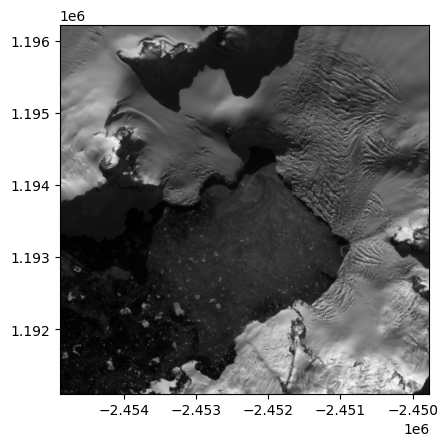

In [8]:
src = rasterio.open(".\scenes\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-8.tif")
img0 = show(src.read(1),transform=src.transform, cmap='gray')

#### Resizing the Data

In [9]:
#creating empty arrays to store our data
imgResize = 512
channels = 3
train_dir, test_dir = create_arrays(512, 3)

In [10]:
resized_training_images = resize_images(imgResize, channels, top_train_list, train_dir)
resized_testing_images = resize_images(imgResize, channels, top_test_list, test_dir)

#### Processing the Labels

##### Loading the mask data

In [11]:
train_mask_path = r'.\mask_scenes\*.tif'

label_train_list = read_data(train_mask_path)
# print(label_train_list)

In [12]:
testing_mask_path = r'.\mask_val\*.tif'

label_test_list = read_data(testing_mask_path)
# print(label_test_list)

#### Visualizing one of the training labels

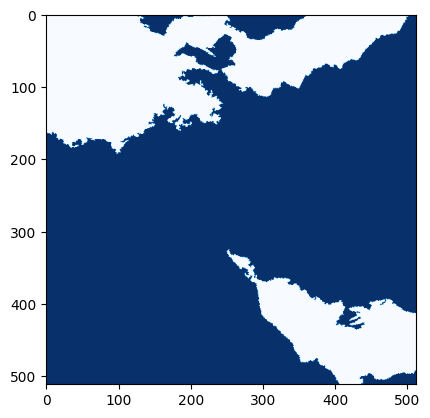

In [13]:
#Lets have a look at our labels
plot_label(label_train_list, 9)



#### Reshaping the Labels

In [14]:
# Define the directory where you want to save the individual label images
label_save_dir_train = './train_label_images/'
label_save_dir_test = './test_label_images/'

# Using the function create_dir to create file directories for saving labelled images for training and testing
create_dir(label_save_dir_train)
create_dir(label_save_dir_test)

In [15]:
# Convert training labels to an array
label_train_total = label_list_to_array(label_train_list, imgResize, 1) 

# Convert testing labels to an array
label_test_total = label_list_to_array(label_test_list, imgResize, 1)

In [16]:
#onehot train label
onehot_label_train_total = onehot_label(label_train_total, label_train_list, imgResize, 2)

#onehot test label
onehot_label_test_total = onehot_label(label_test_total, label_test_list, imgResize, 2)


#### Testing how one-hot-encoded labels appear

[0. 1.]


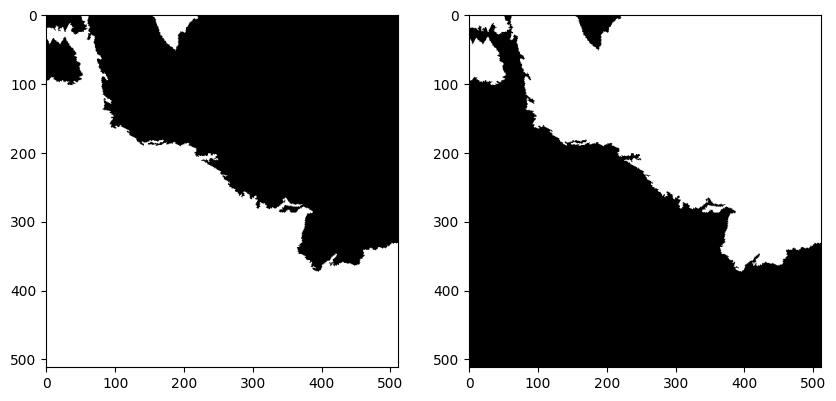

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(onehot_label_test_total[2,:,:,0], cmap='gray')
axes[1].imshow(onehot_label_test_total[2,:,:,1], cmap='gray')
print(np.unique(onehot_label_train_total))

#### Saving the labels

In [18]:
np.save('./train_label_images/label_train.npy', onehot_label_train_total)
np.save('./test_label_images/label_test.npy', onehot_label_test_total)

## Training the Neural Network

Our work is based on the tutorial script provided by *Dr. C. Baumhoer* also inspired by https://github.com/mmorphew/unet_remote_sensing & https://github.com/karolzak/keras-unet


#### Loading the Data

In [19]:
data_train = './train_images/*.tif'
data_test = './test_images/*.tif'

In [20]:
# Load and convert train and testing data into arrays
data_files_train = read_data_array(data_train, imgResize, channels)
data_files_test = read_data_array(data_test, imgResize, channels)

# Load our labels
labels_train = np.load('./train_label_images/label_train.npy')
labels_test  = np.load('./test_label_images/label_test.npy')

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


512 by 512 is chosen since that was how the image collection was resized. 

In [21]:
nx = 512
ny = 512

To improve learning, standardizing globally by subtracting the mean and dividing by the standard deviation.

In [22]:
data_train_scaled = standardize_data(data_files_train)
data_test_scaled = standardize_data(data_files_test)

Assigning the Data to Variables

In [23]:
x_train_data = data_train_scaled #data_train_scaled
y_labels_train = labels_train[:,:,:] # exclude clutter
x_test = data_test_scaled #data_test_scaled
y_labels_test = labels_test[:,:,:]

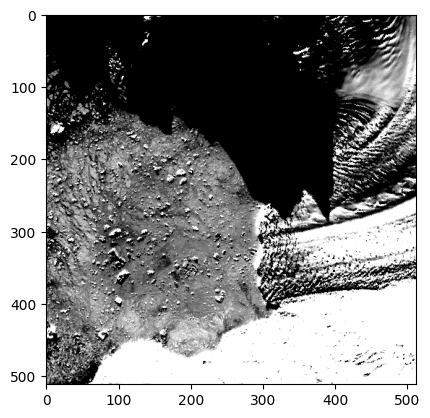

In [24]:
# Plot a random image to see if everything looks alright
plt.imshow(x_train_data[7])

Splitting the dataset into a portion for training and a portion for validation.

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x_train_data, y_labels_train, test_size=0.2, shuffle=True, random_state=1234)

In [26]:
print(x_train.shape)
print(y_train.shape)

(22, 512, 512, 3)
(22, 512, 512, 2)


Augmenting the training data, flipping the images in various ways and addding noise.

In [27]:
x_train, y_train = augment_data(x_training_data=x_train_data, y_training_data=y_train,val=99)

In [28]:
print(x_train.shape)
print(y_train.shape)

(22, 512, 512, 3)
(22, 512, 512, 2)


#### Defining the Neural Network

selecting Adam as an optimizer, categorical_crossentropy as a loss function and tracking metrics.

In [29]:
model = satellite_unet(input_shape=(512, 512, 3), num_classes=2, output_activation='sigmoid', num_layers=3 )
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['batch_normalization[0][0

----- 

Callbacks for instructing Tensorflow on how to behave during training. 

In [30]:
#Let's save our model checkpoints relative to epoch and loss
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

In [31]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint(checkpoint_filepath, monitor='val_categorical_accuracy',
    mode='max',verbose=1, save_best_only=True, save_weights_only=True)
]

#### Training the model

In [32]:
results = model.fit(x_train, y_train, batch_size= 4, epochs=20, callbacks=callbacks,
                   validation_data=(x_val, y_val))

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 0.9262 - categorical_accuracy: 0.5941 - f1: 0.5630 
Epoch 1: val_categorical_accuracy improved from -inf to 0.51733, saving model to weights.01-3.55.h5
6/6 [==============================] - 104s 14s/step - loss: 0.9262 - categorical_accuracy: 0.5941 - f1: 0.5630 - val_loss: 3.5504 - val_categorical_accuracy: 0.5173 - val_f1: 0.4992 - lr: 0.0010
Epoch 2/20
6/6 [==============================] - ETA: 0s - loss: 0.7427 - categorical_accuracy: 0.6803 - f1: 0.6123 
Epoch 2: val_categorical_accuracy improved from 0.51733 to 0.52135, saving model to weights.02-2.63.h5
6/6 [==============================] - 64s 10s/step - loss: 0.7427 - categorical_accuracy: 0.6803 - f1: 0.6123 - val_loss: 2.6292 - val_categorical_accuracy: 0.5213 - val_f1: 0.3698 - lr: 0.0010
Epoch 3/20
6/6 [==============================] - ETA: 0s - loss: 0.6513 - categorical_accuracy: 0.6628 - f1: 0.5759 
Epoch 3: val_categorical_accuracy improved from 0.52

#### Checking the accuracy

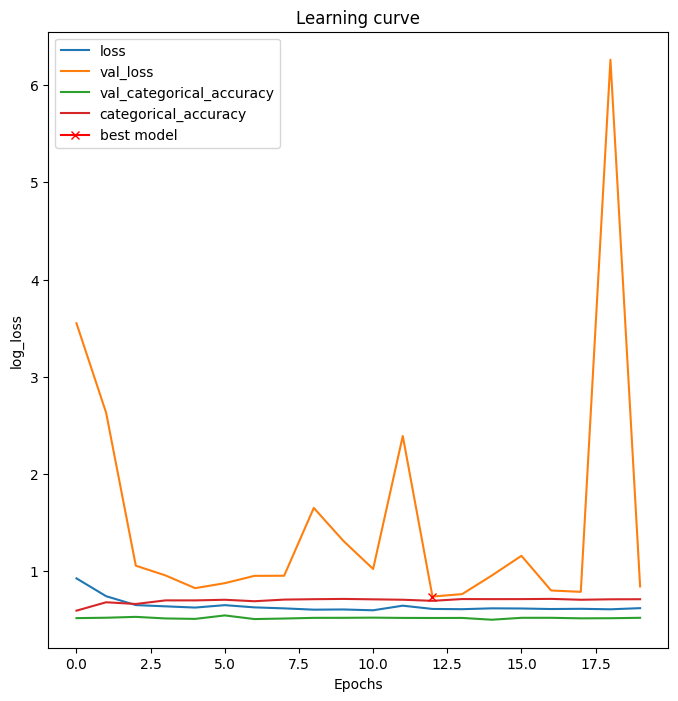

In [33]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#### Evaluating and predictng the trained weights 

In [35]:
# Load best model
# Have a look at all saved models and take the one with the highest epoch value
model.load_weights('./weights.06-0.88.h5')

In [36]:
# Evaluate on test set
eval = model.evaluate(x_test, y_labels_test)
print('Test loss:', eval[0])
print('Test accuracy:', eval[1])

1/1 [==============================] - 6s 6s/step - loss: 0.7129 - categorical_accuracy: 0.6357 - f1: 0.6090
Test loss: 0.7128549814224243
Test accuracy: 0.6357120275497437


In [37]:
# Predict on train, val and test
preds_train = model.predict(x_train[0:10], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(x_test, verbose=1)

1/1 [==============================] - 6s 6s/step


In [38]:
# Threshold prediction probabilities
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

#### Visualizing the Results

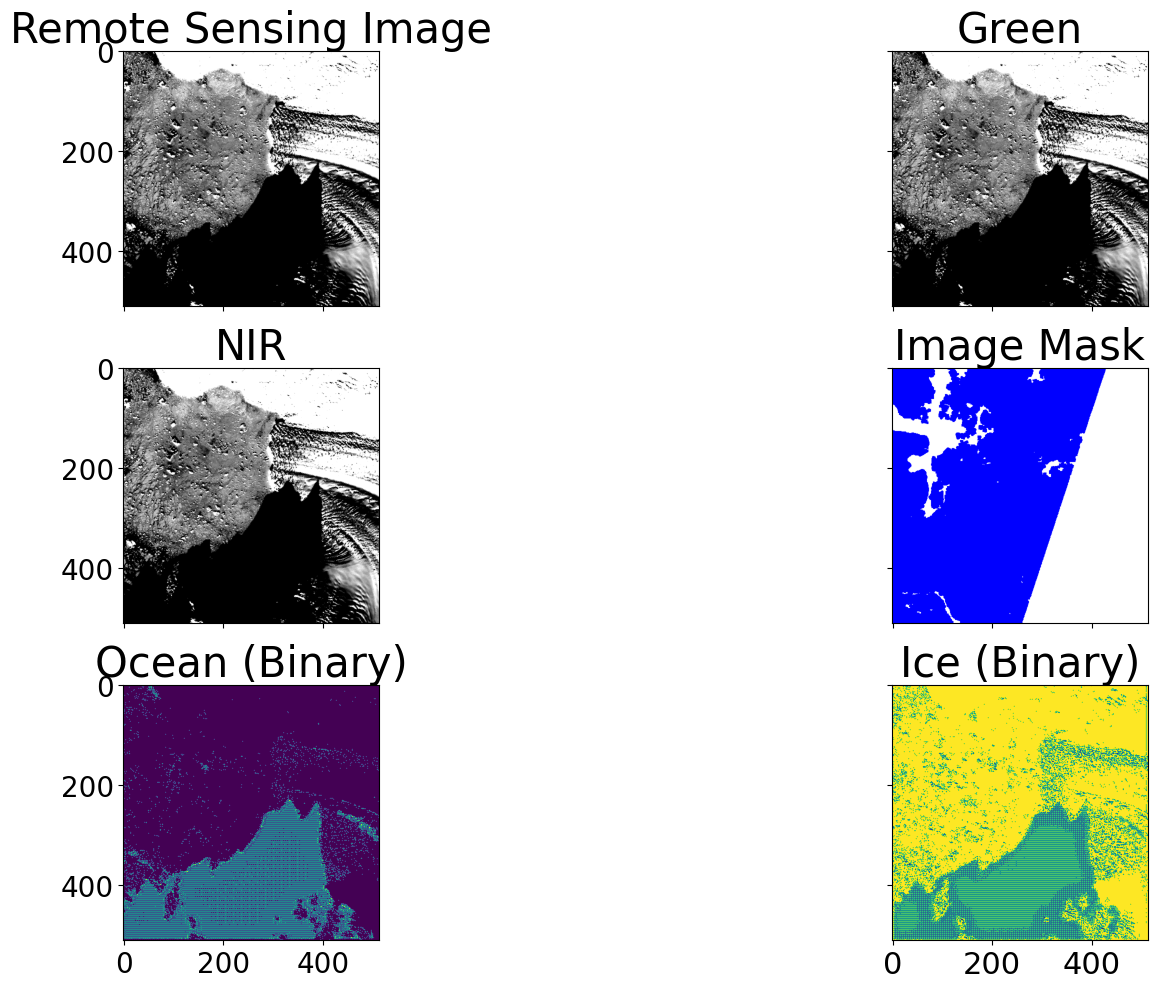

In [40]:
# Let's see how a prediction on the training data looks like
plot_sample_all(x_train, y_train, preds_train, preds_train_t, ix=9, filename='test.png')

Plotting the testing data

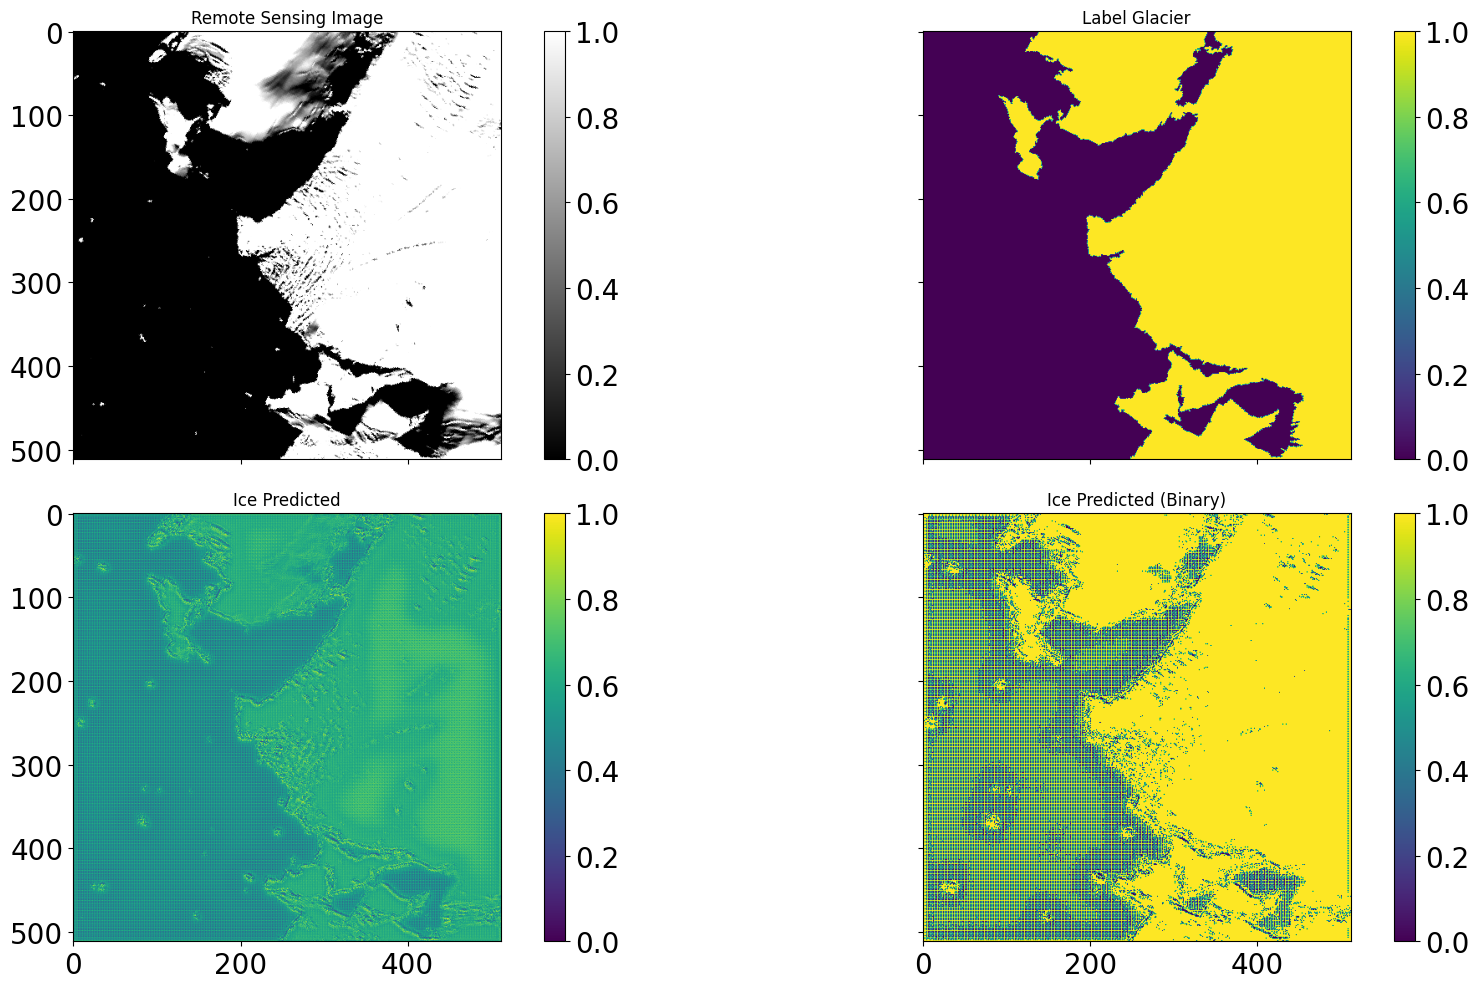

In [41]:
# Check if test data looks all right
plot_sample(x_test, y_labels_test, preds_test, preds_test_t, ix=1)

#### Accuracy Metrics

In [42]:
x_total = np.concatenate((x_train, x_val, x_test), axis=0)
y_total = np.concatenate((y_train, y_val, y_labels_test), axis=0)
pred_total = np.concatenate((preds_train_t, preds_val_t, preds_test_t), axis=0)

In [43]:
print_roc_metrics(y_val, preds_val_t)

Confusion matrix:
[[880366 692498]
 [772225 800639]]
F1 score: 0.5223
Recall score: 0.5090
Precision score: 0.5362
